In [ ]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt
from typing import List

In [ ]:
plt.style.use("dark_background")
plt.figure(figsize = (20, 7))

<Figure size 1440x504 with 0 Axes>

<Figure size 1440x504 with 0 Axes>

In [ ]:
def generate_signal(numOfSignals=1, plot=True):
    fs = 100
    maximun_time= 2 #200
    ti= np.arange(0, maximun_time, 1/fs)
    signal_sine = np.zeros(len(ti))
    frequencies = np.random.randint(200,  size=numOfSignals)
    magnitudes = np.random.randint(200, size=numOfSignals)
    phi = np.random.random(size=numOfSignals)
    phi = phi*(2*math.pi)
    for i in range(numOfSignals):
      signal_sine += [magnitudes[i]*math.sin((2*math.pi*frequencies[i]*t_i + phi[i])) for t_i in ti] 
    if not plot:
      return signal_sine
    plt.figure(figsize = (20, 7))
    plt.plot(ti, signal_sine)
    return signal_sine

In [ ]:
class Signal:
    def __init__(self, signal): #Signal is a vector of values
        self.signal= signal
        self.N =len(signal)
        self.coeff = [] #Array of tuple, [(Real, Imaginary)]
        self.nyquist = self.N/2 

    def ft(self, diffFreq=0):
        if(diffFreq==0):
            self.diffFreq=self.N
        complex_sine_wave_t = np.arange(0, self.N)/self.N  #A vector of time with a samiliar sampling rate to be used when generating each sin 
        self.fr = np.arange(0, self.diffFreq)  #Number of sin signals -with different frequencies- that can be combined to produce the original signal. 
        for i in range(len(self.fr)):
            complex_sine_wave = [cmath.exp(-2*math.pi*1j*self.fr[i]*complex_sine_wave_t[k]) for k in range(len(complex_sine_wave_t))] #generate signal with a specific frequency 
            self.coeff.append(np.dot(complex_sine_wave, self.signal)) #Array of tuple, [(Real, Imaginary) of the those different frequencies]
            #Then we'll get the contribution of each sin in producing the orignial one 
        return self.coeff, self.fr


    def find_frequancy_magnitude_contribution(self):
        #Take the absoluate to get mag
        pts_hz = self.fr[0:int(self.nyquist)]
        normalized_coeff = np.array(self.coeff)/self.N 
        self.magnitude = abs(normalized_coeff)
        self.magnitude = abs(normalized_coeff)*2
        return pts_hz, self.magnitude[0:len(pts_hz)]

    
    def reconstruct(self):
        normalized_coeff = np.array(self.coeff)/self.N 
        complex_sine_wave_t = np.arange(0, self.N)/self.N
        reconstructed = np.zeros(self.N)
        for i in range (len(self.fr)):
            reconstructed = reconstructed + [normalized_coeff[i] * cmath.exp(2*cmath.pi*1j*self.fr[i]*complex_sine_wave_t[j]) for j in range(len(complex_sine_wave_t))]
        plt.plot(complex_sine_wave_t, reconstructed)
    
    def __getitem__(self, k):
        return Signal(self.signal[k])

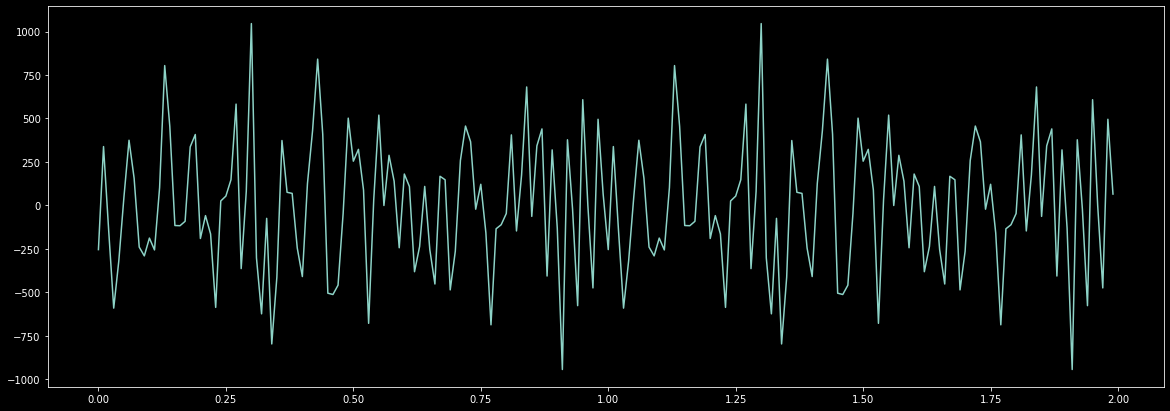

In [ ]:
g_s = generate_signal(20)

s = Signal(g_s)

In [ ]:
class TimeFrequency:
    def __init__(self, full_signal: Signal, *, window_size_ms, overlap_ms, baseline_time_ms):
        self.full_signal = full_signal
        self.N_full_signal = full_signal.N
        self.window_size = window_size_ms / 10
        self.overlap = overlap_ms / 10
        self.baseline_time = baseline_time_ms / 10
        self.window_intervals = []
        self.wt_signals = []
        self.time_points = []
        self.slidding_coffecient = []

    def baseLine(self):
      #length must be specified first, then selcet the indexes.
      # (50/200)*20  --> 50/200 = len()/ len(signal)
      self.baseline_length = math.floor((self.baseline_time/self.N_full_signal)*len(self.slidding_coffecient))
      mean = np.mean(np.mean(self.slidding_coffecient[:self.baseline_length-1])) #[[], []]
      for i in range(len(self.slidding_coffecient)):
         self.slidding_coffecient[i] = self.slidding_coffecient[i]-mean 
      self.power_change = (self.slidding_coffecient-mean)/mean


    def analyze(self):
        # Window, slide, get FFT, store
        self.window_intervals = [
            (int(i*self.overlap), int(i*self.overlap + self.window_size))
            for i in range(int((self.N_full_signal-self.window_size)/self.overlap)+1)
            ]
        for interval in self.window_intervals:
            self.time_points.append(interval[1]/10)
            signal = self.full_signal[interval[0]:interval[1]]
            coeff , fre=signal.ft()
            self.slidding_coffecient.append(coeff)
            self.pts_hz, magn = signal.find_frequancy_magnitude_contribution()
            self.wt_signals.append(magn)
        self.baseLine()
        plt.figure(figsize = (20, 7))
        y = self.pts_hz
        self.wt_signals = np.array(self.wt_signals[self.baseline_length:])
        x = self.time_points[self.baseline_length:]
        z = self.wt_signals.T
        z_min, z_max = -np.abs(z).max(), np.abs(z).max()
        fig, ax = plt.subplots()
        c = ax.pcolormesh(x, y, z, cmap='coolwarm', vmin=z_min, vmax=z_max)
        fig.colorbar(c, ax=ax)
        plt.show(fig)
        return self.slidding_coffecient, fre

<Figure size 1440x504 with 0 Axes>

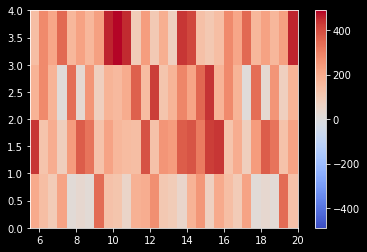

In [ ]:
tf = TimeFrequency(s, window_size_ms=100, overlap_ms=50, baseline_time_ms=500)
tmp_cfs = tf.analyze()

# Phase


In [ ]:
class PhaseConsistancy:
  def __init__(self, trials: List[Signal], *, window_size_ms, overlap_ms, baseline_time_ms):
    self.trials = trials
    self.time_freqs = []
    self.timepts_cfs = []
    for signal in trials: 
      self.time_freqs.append(TimeFrequency(signal, window_size_ms=window_size_ms, overlap_ms=overlap_ms, baseline_time_ms=baseline_time_ms))
      
  def analyze(self):
    print(np.shape(self.trials))
    for tf in self.time_freqs:
      slidding_coffecient, fre = tf.analyze()
      self.timepts_cfs.append(slidding_coffecient)
    # (Number of trials, time_pts, [freq1...freqN])
    print(self.timepts_cfs[0])
    print(np.shape(self.timepts_cfs))
  
  def apply_euler(self):
    avg_euler = []
    for trial in len(self.trials):
      #trials --> (sin)
      avg_euler.append(np.exp(1j*self.fr[i]*complex_sine_wave_t[k]))


(3,)


<Figure size 1440x504 with 0 Axes>

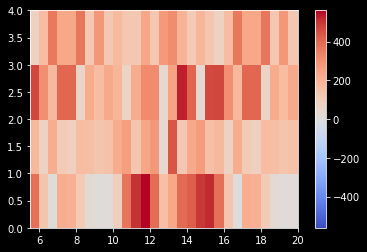

<Figure size 1440x504 with 0 Axes>

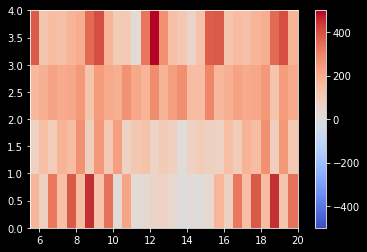

<Figure size 1440x504 with 0 Axes>

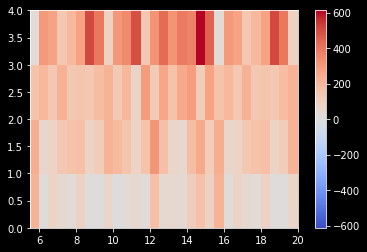

[array([-2343.78074525+2.98427949e-14j,   861.0762431 -7.35530482e+01j,
         209.40640461-1.13614632e+03j,   819.40836982+5.05911428e+01j,
         -60.0347378 -1.83488997e+02j,  -329.05723667-6.74281678e-14j,
         -60.0347378 +1.83488997e+02j,   819.40836982-5.05911428e+01j,
         209.40640461+1.13614632e+03j,   861.0762431 +7.35530482e+01j]), array([-2613.70295578+2.98427949e-14j,  -858.29630743-6.21893010e+02j,
        1329.77774566-1.10237269e+03j,  -880.44872288+5.86889595e+02j,
         -43.04448152-2.36840252e+02j,   369.75717817+5.62183482e-13j,
         -43.04448152+2.36840252e+02j,  -880.44872288-5.86889595e+02j,
        1329.77774566+1.10237269e+03j,  -858.29630743+6.21893010e+02j]), array([-1762.76858347+2.98427949e-14j,  1041.95786348+1.14388345e+03j,
        1382.63271449-1.04856523e+03j,   732.38467716-3.09947991e+02j,
        -201.76195342-1.02985463e+03j,   848.81852582+7.31832970e-13j,
        -201.76195342+1.02985463e+03j,   732.38467716+3.09947991e+02j,
 

In [ ]:
trial1 = Signal(generate_signal(20, plot=False))
trial2 = Signal(generate_signal(20, plot=False))
trial3 = Signal(generate_signal(20, plot=False))
phscs = PhaseConsistancy([trial1, trial2, trial3], window_size_ms=100, overlap_ms=50, baseline_time_ms=500)
phscs.analyze()